In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from numba import jit
import time
import gc

C:\Users\Amin\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Compute gini

# from CPMP's kernel https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
@jit
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / np.float(ntrue * (n - ntrue))
    return gini

In [3]:
# Funcitons from olivier's kernel
# https://www.kaggle.com/ogrellier/xgb-classifier-upsampling-lb-0-283

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]


def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))


def target_encode(trn_series=None,    # Revised to encode validation series
                  val_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_val_series = pd.merge(
        val_series.to_frame(val_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=val_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_val_series.index = val_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_val_series, noise_level), add_noise(ft_tst_series, noise_level)

In [4]:
# from olivier
train_features = [
    "ps_car_13",  #            : 1571.65 / shadow  609.23
	"ps_reg_03",  #            : 1408.42 / shadow  511.15
	"ps_ind_05_cat",  #        : 1387.87 / shadow   84.72
	"ps_ind_03",  #            : 1219.47 / shadow  230.55
	"ps_ind_15",  #            :  922.18 / shadow  242.00
	"ps_reg_02",  #            :  920.65 / shadow  267.50
	"ps_car_14",  #            :  798.48 / shadow  549.58
	"ps_car_12",  #            :  731.93 / shadow  293.62
	"ps_car_01_cat",  #        :  698.07 / shadow  178.72
	"ps_car_07_cat",  #        :  694.53 / shadow   36.35
	"ps_ind_17_bin",  #        :  620.77 / shadow   23.15
	"ps_car_03_cat",  #        :  611.73 / shadow   50.67
	"ps_reg_01",  #            :  598.60 / shadow  178.57
	"ps_car_15",  #            :  593.35 / shadow  226.43
	"ps_ind_01",  #            :  547.32 / shadow  154.58
	"ps_ind_16_bin",  #        :  475.37 / shadow   34.17
	"ps_ind_07_bin",  #        :  435.28 / shadow   28.92
	"ps_car_06_cat",  #        :  398.02 / shadow  212.43
	"ps_car_04_cat",  #        :  376.87 / shadow   76.98
	"ps_ind_06_bin",  #        :  370.97 / shadow   36.13
	"ps_car_09_cat",  #        :  214.12 / shadow   81.38
	"ps_car_02_cat",  #        :  203.03 / shadow   26.67
	"ps_ind_02_cat",  #        :  189.47 / shadow   65.68
	"ps_car_11",  #            :  173.28 / shadow   76.45
	"ps_car_05_cat",  #        :  172.75 / shadow   62.92
	"ps_calc_09",  #           :  169.13 / shadow  129.72
	"ps_calc_05",  #           :  148.83 / shadow  120.68
	"ps_ind_08_bin",  #        :  140.73 / shadow   27.63
	"ps_car_08_cat",  #        :  120.87 / shadow   28.82
	"ps_ind_09_bin",  #        :  113.92 / shadow   27.05
	"ps_ind_04_cat",  #        :  107.27 / shadow   37.43
	"ps_ind_18_bin",  #        :   77.42 / shadow   25.97
	"ps_ind_12_bin",  #        :   39.67 / shadow   15.52
	"ps_ind_14",  #            :   37.37 / shadow   16.65
]
# add combinations
combs = [
    ('ps_reg_01', 'ps_car_02_cat'),  
    ('ps_reg_01', 'ps_car_04_cat'),
]

In [5]:
# Read data
train_df = pd.read_csv('Data/train.csv', na_values="-1") # .iloc[0:200,:]
test_df = pd.read_csv('Data/test.csv', na_values="-1")

In [6]:
target = train_df["target"]
ntrain = train_df.shape[0]
data = pd.concat([train_df[train_features], test_df[train_features]], axis=0, ignore_index=True)
print data.shape
#del train_df, test_df
gc.collect()

(1488028, 34)


390

In [7]:
# replace missing values with median
columns = ["ps_reg_03", "ps_car_11", "ps_car_12", "ps_car_14"]
data[columns] = data[columns].replace(-1, np.NaN)
for col in columns:
    med = data.loc[:ntrain-1, col].dropna().median()
    data.loc[data[col].isnull(), col] = med
    print med

0.8015609771
3.0
0.3741657387
0.3734969879


In [8]:
from sklearn.preprocessing import LabelEncoder
columns = [f for f in data.columns if "_cat" in f]

for col in columns:
    data.loc[data[col].isnull(), col] = -1
    enc = LabelEncoder()
    data[col] = enc.fit_transform(data[col])

In [9]:
threshol = 500
columns = [f for f in data.columns if "_cat" in f]

for col in columns:
    temp = data.loc[:ntrain-1, col]
    density = temp.value_counts().sort_values()
    count = density.iloc[0]
    while count < threshol:
        ix0 = density.index[0]; ix1 = density.index[1]
        data.loc[data[col] == ix0, col] = ix1

        temp = data.loc[:ntrain-1, col]
        density = temp.value_counts().sort_values()
        count = density.iloc[0]

In [10]:
# Process data
start = time.time()
for n_c, (f1, f2) in enumerate(combs):
    name1 = f1 + "_plus_" + f2
    print('current feature %60s %4d in %5.1f', (name1, n_c + 1, (time.time() - start) / 60))

    data[name1] = data[f1].apply(lambda x: str(x)) + "_" + data[f2].apply(lambda x: str(x))
    # Label Encode
    lbl = LabelEncoder()
    lbl.fit(list(data[name1].values))
    data[name1] = lbl.transform(list(data[name1].values))
    


('current feature %60s %4d in %5.1f', ('ps_reg_01_plus_ps_car_02_cat', 1, 1.6669432322184246e-05))
('current feature %60s %4d in %5.1f', ('ps_reg_01_plus_ps_car_04_cat', 2, 0.05691667000452678))


In [11]:
from sklearn.preprocessing import MinMaxScaler
columns = [f for f in data.columns if "_bin" not in f and "_cat" not in f]

min_max_scaler = MinMaxScaler()
data[columns] = min_max_scaler.fit_transform(list(data[columns].values))

In [12]:
f_cats = [f for f in train_features if "_cat" in f]

for col in f_cats:
    tt = pd.get_dummies(data[col])
    tt.columns = [col+str(x) for x in tt.columns]
#    print tt.columns
#    data = data.drop(col, axis=1)
    data = pd.concat([data, tt], axis=1)
    

In [16]:
X = data.loc[:ntrain-1, :]
test = data.loc[ntrain:, :]
print X.shape, test.shape

f_cats = [f for f in X.columns if "_cat" in f]

(595212, 107) (892816, 107)


In [17]:
# Set up classifier
from sklearn.linear_model import LogisticRegression
cc = 1.0
model = LogisticRegression(C=cc)

In [18]:
y_valid_pred = 0*target
y_test_pred = 0

# Set up folds
from sklearn.model_selection import StratifiedKFold
K = 10
skf = StratifiedKFold(n_splits = K, random_state = 1001, shuffle = True)
np.random.seed(0)

for i, (train_index, test_index) in enumerate(skf.split(X, target)):
    
    # Create data for this fold
    y_train, y_valid = target.iloc[train_index].copy(), target.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()
    X_test = test.copy()
    print( "\nFold ", i)
    
#    Enocode data
    for f in f_cats:
        X_train[f + "_avg"], X_valid[f + "_avg"], X_test[f + "_avg"] = target_encode(
                                                        trn_series=X_train[f],
                                                        val_series=X_valid[f],
                                                        tst_series=X_test[f],
                                                        target=y_train,
                                                        min_samples_leaf=200,
                                                        smoothing=10,
                                                        noise_level=0
                                                        )
        
        X_train = X_train.drop(f, axis=1)
        X_valid = X_valid.drop(f, axis=1)
        X_test = X_test.drop(f, axis=1)

    eval_set=[(X_valid,y_valid)]
    fit_model = model.fit( X_train, y_train) 
#     , 
#                                eval_set=eval_set,
#                                eval_metric=gini_xgb,
#                                early_stopping_rounds=50,
#                                verbose=False
#                              )
#    print( "  Best N trees = ", model.best_ntree_limit )
#    print( "  Best gini = ", model.best_score )
        
    # Generate validation predictions for this fold
    pred = fit_model.predict_proba(X_valid)[:,1]
    print( "  Gini = ", eval_gini(y_valid, pred) )
    y_valid_pred.iloc[test_index] = pred
    
    # Accumulate test set predictions
    y_test_pred += fit_model.predict_proba(X_test)[:,1]
    
    del X_test, X_train, X_valid, y_train
    
y_test_pred /= K  # Average test set predictions

print( "\nGini for full training set:" )
print eval_gini(target, y_valid_pred)

# ('\nFold ', 0)
# ('  Gini = ', 0.26945233670572155)
# ('\nFold ', 1)
# ('  Gini = ', 0.26236991964249556)

('\nFold ', 0)
('  Gini = ', 0.2526404970710425)
('\nFold ', 1)


KeyboardInterrupt: 

In [64]:
y_valid_pred = 0*target
y_test_pred = 0

# Set up folds
from sklearn.model_selection import StratifiedKFold
K = 10
skf = StratifiedKFold(n_splits = K, random_state = 1, shuffle = True)
np.random.seed(0)

for i, (train_index, test_index) in enumerate(skf.split(X, target)):
    
    # Create data for this fold
    y_train, y_valid = target.iloc[train_index].copy(), target.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()
    X_test = test.copy()
    print( "\nFold ", i)
    
#    Enocode data
    for f in f_cats:
        X_train[f + "_avg"], X_valid[f + "_avg"], X_test[f + "_avg"] = target_encode(
                                                        trn_series=X_train[f],
                                                        val_series=X_valid[f],
                                                        tst_series=X_test[f],
                                                        target=y_train,
                                                        min_samples_leaf=200,
                                                        smoothing=10,
                                                        noise_level=0
                                                        )

    eval_set=[(X_valid,y_valid)]
    fit_model = model.fit( X_train, y_train) 
#     , 
#                                eval_set=eval_set,
#                                eval_metric=gini_xgb,
#                                early_stopping_rounds=50,
#                                verbose=False
#                              )
#    print( "  Best N trees = ", model.best_ntree_limit )
#    print( "  Best gini = ", model.best_score )
        
    # Generate validation predictions for this fold
    pred = fit_model.predict_proba(X_valid)[:,1]
    print( "  Gini = ", eval_gini(y_valid, pred) )
    y_valid_pred.iloc[test_index] = pred
    
    # Accumulate test set predictions
    y_test_pred += fit_model.predict_proba(X_test)[:,1]
    
    del X_test, X_train, X_valid, y_train
    
y_test_pred /= K  # Average test set predictions

print( "\nGini for full training set:" )
print eval_gini(target, y_valid_pred)

('\nFold ', 0)
('  Gini = ', 0.2747237047888599)
('\nFold ', 1)
('  Gini = ', 0.2903885328086301)
('\nFold ', 2)
('  Gini = ', 0.2845677883462656)
('\nFold ', 3)
('  Gini = ', 0.2791717796734918)
('\nFold ', 4)
('  Gini = ', 0.28041380074974465)
('\nFold ', 5)
('  Gini = ', 0.2799817145963156)
('\nFold ', 6)
('  Gini = ', 0.29940697361166657)
('\nFold ', 7)
('  Gini = ', 0.2843443779538213)
('\nFold ', 8)
('  Gini = ', 0.29356744981255933)
('\nFold ', 9)
('  Gini = ', 0.27144272561193084)

Gini for full training set:
0.283699644598


In [65]:
X.loc[:, "xgbr"] = y_valid_pred
test.loc[:,"xgbr"] = y_test_pred

In [19]:
# Set up classifier
model = XGBClassifier(    
                        n_estimators=2000,
                        max_depth=4,
                        objective="binary:logistic",
                        learning_rate=0.07, 
                        subsample=.8,
                        min_child_weight=.77,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )

In [20]:
y_valid_pred = 0*target
y_test_pred = 0

# Set up folds
from sklearn.model_selection import StratifiedKFold
K = 10
skf = StratifiedKFold(n_splits = K, random_state = 2, shuffle = True)
np.random.seed(0)

for i, (train_index, test_index) in enumerate(skf.split(X, target)):
    
    # Create data for this fold
    y_train, y_valid = target.iloc[train_index].copy(), target.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()
    X_test = test.copy()
    print( "\nFold ", i)
    
#    Enocode data
    for f in f_cats:
        X_train[f + "_avg"], X_valid[f + "_avg"], X_test[f + "_avg"] = target_encode(
                                                        trn_series=X_train[f],
                                                        val_series=X_valid[f],
                                                        tst_series=X_test[f],
                                                        target=y_train,
                                                        min_samples_leaf=200,
                                                        smoothing=10,
                                                        noise_level=0
                                                        )

    eval_set=[(X_valid,y_valid)]
    fit_model = model.fit( X_train, y_train, 
                               eval_set=eval_set,
                               eval_metric=gini_xgb,
                               early_stopping_rounds=50,
                               verbose=False
                             )
    print( "  Best N trees = ", model.best_ntree_limit )
    print( "  Best gini = ", model.best_score )
        
    # Generate validation predictions for this fold
    pred = fit_model.predict_proba(X_valid)[:,1]
    print( "  Gini = ", eval_gini(y_valid, pred) )
    y_valid_pred.iloc[test_index] = pred
    
    # Accumulate test set predictions
    y_test_pred += fit_model.predict_proba(X_test)[:,1]
    
    del X_test, X_train, X_valid, y_train
    
y_test_pred /= K  # Average test set predictions

print( "\nGini for full training set:" )
print eval_gini(target, y_valid_pred)

('\nFold ', 0)


ZeroDivisionError: integer division or modulo by zero

In [73]:
fit_model.booster().get_fscore()

{'ps_calc_05': 1,
 'ps_calc_09': 7,
 'ps_car_01_cat': 4,
 'ps_car_01_cat_avg': 8,
 'ps_car_03_cat': 7,
 'ps_car_04_cat': 2,
 'ps_car_05_cat': 4,
 'ps_car_06_cat': 5,
 'ps_car_06_cat_avg': 5,
 'ps_car_07_cat': 7,
 'ps_car_07_cat_avg': 1,
 'ps_car_09_cat': 4,
 'ps_car_09_cat_avg': 10,
 'ps_car_11': 1,
 'ps_car_12': 1,
 'ps_car_13': 40,
 'ps_car_14': 5,
 'ps_car_15': 4,
 'ps_ind_01': 4,
 'ps_ind_02_cat': 2,
 'ps_ind_02_cat_avg': 1,
 'ps_ind_03': 13,
 'ps_ind_04_cat': 1,
 'ps_ind_05_cat': 6,
 'ps_ind_05_cat_avg': 18,
 'ps_ind_06_bin': 2,
 'ps_ind_07_bin': 3,
 'ps_ind_09_bin': 2,
 'ps_ind_12_bin': 1,
 'ps_ind_15': 18,
 'ps_ind_16_bin': 3,
 'ps_ind_17_bin': 17,
 'ps_ind_18_bin': 1,
 'ps_reg_01_plus_ps_car_02_cat': 3,
 'ps_reg_01_plus_ps_car_02_cat_avg': 8,
 'ps_reg_01_plus_ps_car_04_cat': 4,
 'ps_reg_01_plus_ps_car_04_cat_avg': 16,
 'ps_reg_02': 11,
 'ps_reg_03': 14,
 'xgbr': 242}

In [74]:
import operator
importance = fit_model.booster().get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

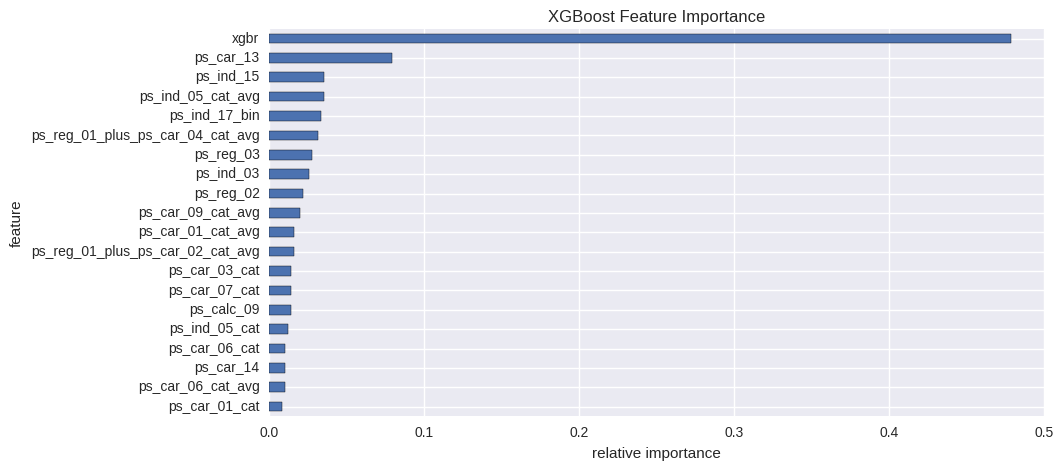

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

plt.figure()
df[-20:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 5))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()